**Detecting marine heatwave events with xmhw**<br>
----

In [1]:
import xarray as xr
import numpy as np
import datetime  # this is needed only to run original code
import dask

In [45]:
# you need this if running original code otherwise it really slows down
import warnings
warnings.filterwarnings('ignore')

**Import functions from xmhw**<br><br>
We separated the calculation of the the climatologies from the identification of marine heat waves (mhw). In this way we have two separate functions and you can save a re-use the threshold while experimenting with different settings for the detection part.

In [2]:
from xmhw.xmhw import threshold, detect

**Setting up dask**<br>

I am not dask expert, this is something I tried to make the code run faster and making sure that cell grids are processed in parallel. I use dask.delayed to create delayed functions and that speed up the calculation. It also helps computing the threshold before the detection step.

In [3]:
# configure the dask scheduler to threaded.
# The threaded scheduler executes computations with a local multiprocessing.pool.ThreadPool 
# so you can run multithread 
dask.config.set(scheduler='threads')

In [4]:
# import ProgressBar to help with diagnostic
from dask.diagnostics import ProgressBar

**Example calculation**<br>

Using NOAA OISST timeseries, I am selecting a smaller region to demo xmhw code.<br>
Before calculaitng anything the function land_check() (from xmhw.identify) is called. This function does has two steps:<br>
  - stacks all dimensions but "time" in a new 'cell' dimension;
  - removes all the land points, these are assumed to have np.nan values along the time axis
   
NB If the timeseries you want to use has a time axis which is not called 'time' you can specify that.<br>

In [146]:
# using NOAA oisst as timeseries
ds =xr.open_mfdataset('/g/data/ua8/NOAA_OISST/AVHRR/v2-1_modified/timeseries/oisst_timeseries_*.nc',
                        concat_dim='time', combine='nested', chunks={'time':-1, 'lat': 'auto', 'lon': 'auto'})
# removing zlev dimension
sst =ds['sst'].squeeze()
sst = sst.drop('zlev')
# for the moment getting small region to test
# This correspond to ... ocean cell grid points
tos = sst.sel(lat=slice(-44,-41),lon=slice(144, 149))
ds

,Array,Chunk
Bytes,59.69 GB,101.19 MB
Shape,"(14392, 1, 720, 1440)","(366, 1, 240, 288)"
Count,3843 Tasks,1148 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,59.69 GB,101.19 MB
Shape,"(14392, 1, 720, 1440)","(366, 1, 240, 288)"
Count,3843 Tasks,1148 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [6]:
# data is small enough to have 1 chunk)
# NB for each cell the timeseries should be in same chunk, for this reason chunk({'time-dimension': -1}) 
# is included in the module where necessary
ts = tos.chunk({'time':-1, 'lat': 'auto', 'lon': 'auto'})
ts

<xarray.DataArray 'sst' (time: 14392, lat: 12, lon: 20)>
dask.array<rechunk-merge, shape=(14392, 12, 20), dtype=float32, chunksize=(14392, 12, 20), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01T12:00:00 ... 2021-01-25T12:00:00
  * lon      (lon) float32 144.125 144.375 144.625 ... 148.375 148.625 148.875
  * lat      (lat) float32 -43.875 -43.625 -43.375 ... -41.625 -41.375 -41.125
Attributes:
    long_name:  Daily sea surface temperature
    units:      degree_C

**Calculate threshold separately and save it to file**<br>


The *threshold* function will calculate the climatologies, ie.e seasonal average and threhsold, then use to detect marine heat waves (mhw) along the timeseries.<br>This function mimic the original code behaviour including returning a dictionary. We are looking at changing this so it will return a dataset instead.<br> As for the original several parameters can be set:
````
threshold(temp, tdim='time', climatologyPeriod=[None,None], pctile=90, windowHalfWidth=5,
          smoothPercentile=True, smoothPercentileWidth=31, maxPadLength=False, coldSpells=False, Ly=False)
````
Where *temp* is the temperature timeseries, this is the only input needed, if you're happy with the default settings and if you're time dimension is called 'time'.<br><br>
In the following example we're using all default settings for threshold.

In [9]:
# This function is using a `delayed` sub-function, but we don't need to call compute because this is done directly
# in the function definition
with ProgressBar():
    climds = threshold(ts)
climds

[########################################] | 100% Completed | 35.0s
[########################################] | 100% Completed | 11min 43.4s


<xarray.Dataset>
Dimensions:  (doy: 366, lat: 12, lon: 20)
Coordinates:
  * doy      (doy) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
  * lat      (lat) float64 -43.88 -43.62 -43.38 -43.12 ... -41.62 -41.38 -41.12
  * lon      (lon) float64 144.1 144.4 144.6 144.9 ... 148.1 148.4 148.6 148.9
Data variables:
    thresh   (doy, lat, lon) float64 14.86 14.95 15.03 ... 17.82 18.11 18.59
    seas     (doy, lat, lon) float32 13.502463 13.599785 ... 16.764244 17.105808
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Seasonal climatology and threshold calculated using xmh...
    history:          2021-05-06: calculated using xmhw code https://github.c...
    xmhw_parameters:  Threshold calculated using:\n    90 percentile;\n    cl...

It is important to notice that differently from the original function which takes a numpy 1D array, because we are using xarray we can pass a 3D array (in fact we could pass any n-dim array) and the code will deal with it.<br>
We selected a 12X20 lat-lon region and of these 135 grid cells are ocean. <br>

The function return a dataset with the arrays: <br><br>
   - **thresh** - for the threshold timeseries
   - **seas** - for the seasonal mean
<br>Differently from the original function, here the climatologies are saved not along the entire timeseries but only along the new **doy** dimension. Given that xarray keeps the coordinates with the arrays there is no need to repeat the climatologies along the time axis.<br>
We also try to follow the CF conventions and define appropriate variables attributes and some global attributes that record the parameters used to calculate the threshold for provenance.

In [ ]:
# save threshold and seasonal average to netcdf file
climds.to_netcdf('climatology_tas.nc')

In [9]:
# if already saved use clim from file
#climds = xr.open_dataset('climatology_tas.nc')
#climds

<xarray.Dataset>
Dimensions:    (doy: 366, lat: 12, lon: 20)
Coordinates:
  * doy        (doy) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
  * lat        (lat) float64 -43.88 -43.62 -43.38 ... -41.62 -41.38 -41.12
  * lon        (lon) float64 144.1 144.4 144.6 144.9 ... 148.1 148.4 148.6 148.9
Data variables:
    threshold  (doy, lat, lon) float64 ...
    seasonal   (doy, lat, lon) float32 ...

**Filter MHW passing calculated climatologies to detect**<br>
The *detect* function indetifies all the mhw events and their characteristics. Corresponds to the second part of the original detect function and again mimic the logic of the original code.

````
    detect(temp, th, se, minDuration=5, joinAcrossGaps=True, maxGap=2,
           maxPadLength=None, coldSpells=False, tdim='time')
````
This time you have to pass the timeseries, the threshold and the seasonal average. The other parameters are optional.<br>
The results are stored differently form the original function:
````
   Original structure: 
       - mhw is a dictionary
       - each characteristic is a key with a list of values, each value represent an event
       - Ex.  mhw['intensity_max'][ev]
````
First of all, the new function returns an xarray dataset not a dictionary. Most importantly, there is one variable for each calculated field. The events are stored all together not as separate arrays.<br> Let's see an example, we are using all default settings for MHW filter.

In [11]:
with ProgressBar():
    mhwds = detect(ts, climds['threshold'], climds['seasonal'])
mhwds

[########################################] | 100% Completed | 35.6s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  2min 31.5s
loop completed


<xarray.Dataset>
Dimensions:                         (events: 2065, lat: 12, lon: 20)
Coordinates:
  * events                          (events) float64 91.0 116.0 ... 1.438e+04
  * lat                             (lat) float64 -43.88 -43.62 ... -41.12
  * lon                             (lon) float64 144.1 144.4 ... 148.6 148.9
Data variables:
    event                           (events, lat, lon) float64 nan nan ... nan
    index_start                     (events, lat, lon) float64 nan nan ... nan
    index_end                       (events, lat, lon) float64 nan nan ... nan
    time_start                      (events, lat, lon) datetime64[ns] NaT ......
    time_end                        (events, lat, lon) datetime64[ns] NaT ......
    intensity_max                   (events, lat, lon) float32 nan nan ... nan
    intensity_mean                  (events, lat, lon) float32 nan nan ... nan
    intensity_cumulative            (events, lat, lon) float32 nan nan ... nan
    intensity_mean_relThresh        (events, lat, lon) float64 nan nan ... nan
    intensity_cumulative_relThresh  (events, lat, lon) float64 nan nan ... nan
    intensity_mean_abs              (events, lat, lon) float32 nan nan ... nan
    intensity_cumulative_abs        (events, lat, lon) float32 nan nan ... nan
    duration_moderate               (events, lat, lon) float64 nan nan ... nan
    duration_strong                 (events, lat, lon) float64 nan nan ... nan
    duration_severe                 (events, lat, lon) float64 nan nan ... nan
    duration_extreme                (events, lat, lon) float64 nan nan ... nan
    index_peak                      (events, lat, lon) float64 nan nan ... nan
    intensity_var                   (events, lat, lon) float32 nan nan ... nan
    intensity_max_relThresh         (events, lat, lon) float64 nan nan ... nan
    intensity_max_abs               (events, lat, lon) float32 nan nan ... nan
    intensity_var_relThresh         (events, lat, lon) float64 nan nan ... nan
    intensity_var_abs               (events, lat, lon) float32 nan nan ... nan
    category                        (events, lat, lon) float64 nan nan ... nan
    rate_onset                      (events, lat, lon) float64 nan nan ... nan
    rate_decline                    (events, lat, lon) float64 nan nan ... nan

This time the function returns a xarray dataset, 'cell' dimension is still present, so we need to unstack it if we want back the latitude and longitude grid.

The resulting dataset has a new dimension `events` which is defined as the starting day of an mhw event.
And each variable is a characteristic of the detected mhw:
````event         (events, lat, lon)
    index_start   (events, lat, lon)
    index_end     (events, lat, lon)
    time_start    (events, lat, lon)
    time_end      (events, lat, lon)
    intensity_max (events, lat, lon)
    intensity_mean(events, lat, lon)
    ...

````

The *events* dimension size is determined by the number of separate events individuated. Separate events have different startung times. This means that if two different cells have events starting at timestep=50, these event will have the same index along the dimension `events` regardless on their duration.<br>
Clearly this is an approximation because if an event starts even a timestep later is classified as separate.
This is because as for the original code, each event is individuated cell by cell. 

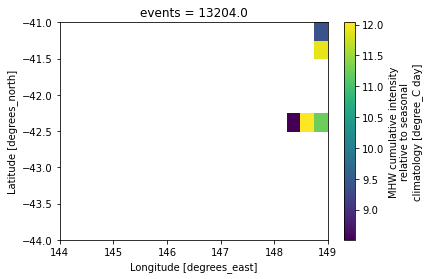

In [14]:
mhwds.intensity_cumulative[1768,:,:].plot()

In [ ]:
# save mhw to yearly netcdf files (to split size if you have a really long timeseries)
#years, datasets = zip(*mhwds.groupby("time.year"))
#paths = ["mhw_%s.nc" % y for y in years]
#xr.save_mfdataset(datasets, paths)
# you can use this if only doing a subset

mhwds.to_netcdf('mhw_tas.nc')

**Block average**<br><br>
The blockAverage function on the original MHW code is used to calculate statistics along a block of time. The default is 1 year block. If the time series used starts or ends in the middle of the year then the results for this two years have to be treated carefully.<br>
Most of the statistics calculated on the block are averages. Given that the mhw properties are saved now as an array we can simply calculate a mean after grouping by year or "bins"of years on the entire dataset.<br>
Below I'm showing the current stage of a new block_average function, which I'm adding to xmhw. 

In [144]:
def block_average(mhwds, temp=None, clim=None, blockLength=1, removeMissing=False):
    '''
    Options:

      blockLength            Size of block (in years) over which to calculate the
                             averaged MHW properties. Must be an integer greater than
                             or equal to 1 (DEFAULT = 1 [year])
      removeMissing          Boolean switch indicating whether to remove (set = NaN)
                             statistics for any blocks in which there were missing 
                             temperature values (DEFAULT = FALSE)
      clim                   The temperature climatology (including missing value information)
                             as output by marineHeatWaves.detect 
      temp                   Temperature time series. If included mhwBlock will output block
                             averages of mean, max, and min temperature (DEFAULT = None but
                             required if removeMissing = TRUE)
                             

                             If both clim and temp are provided, this will output annual counts
                             of moderate, strong, severe, and extreme days.

    Notes:

      This function assumes that the input time vector consists of continuous daily values. Note that
      in the case of time ranges which start and end part-way through the calendar year, the block
      averages at the endpoints, for which there is less than a block length of data, will need to be
      interpreted with care.

    '''
    # Check if all the necessary variables are present 
    if removeMissing and not temp:
        print(f'To remove missing values you need to pass the original temperature timeseries')
        return None
    # Check what stats to output
    # if temp included calculate stats for it, if clim also included calculate categories days count
    sw_temp=False
    sw_cats=False
    if temp is not None:
        sw_temp = True
        if clim is not None:
            sw_cats = True
        else:
            sw_cats = False
    
    # create bins based on blockLength to used with groupby_bins
    # NB if the last bin has less than blockLength years, it won't be included.
    # So I'm using last-year+blockLength+1 to make sure we get a bin for last year/s included
    bins=range(1981,2021+blockLength+1,blockLength)

    # calculate mean of variables after grouping by year
    block = mhwds.groupby_bins(mhwds.time_start.dt.year, bins, right=False).mean()
    
    # remove averages of indexes, events and category (which need special treatment)
    block = block.drop(['event', 'index_start', 'index_end', 'category'] )
    
    # Other stats can be calculated one by one
    # calculate maximum of intensity_max
    block['intensity_max_max'] = mhwds.intensity_max.groupby_bins(mhwds.time_start.dt.year, bins, right=False).max()
    
    # if sw_temp
    if sw_temp:
        pass
    if sw_cats:
        block['moderate_days'] = mhwds.duration_moderate.groupby_bins(mhwds.time_start.dt.year, bins, right=False).sum()
    
    return block

In [145]:
# To call with standard parameters, below results for a grid point are shown compared to the orginal function 
block = block_average(mhwds)

**Find MHW using original code**<br><br>

In [48]:
#%%time
#from datetime import date
from marineHeatWaves import detect as orig_detect
from marineHeatWaves import blockAverage

# create necessary time numpy array
t = np.arange(datetime.date(1981,9,1).toordinal(),datetime.date(2021,1,25).toordinal()+1)
sst = tos[:,0,0].squeeze().values
# call function with default settings
orig_mhw, orig_clim = orig_detect(t, sst)

In [80]:
# test to see if groupby_bins as used in the new block_average function produces the same values, 
# first of all I need to go from a list of values to an xarray array for one variable to apply groupby_bins
import pandas
start = pandas.to_datetime(orig_mhw['date_start'])
intensity_mean = xr.DataArray(orig_mhw['intensity_mean'],
                              dims=['start'], 
                              coords=dict(start=start))
intensity_mean

<xarray.DataArray (start: 74)>
array([1.13040335, 1.48495976, 1.79183788, 1.75223406, 1.88849983,
       1.35655273, 1.68309756, 1.56012382, 0.94375492, 1.02434419,
       1.81595106, 1.57068209, 1.27372462, 1.00691628, 1.86110477,
       1.67387067, 0.96929742, 1.06742299, 1.05429326, 1.28925075,
       1.47498902, 1.33079218, 1.13246348, 1.56100337, 1.87613111,
       1.86073895, 1.78940663, 1.41918379, 1.27958847, 1.26576757,
       1.45750364, 1.80377292, 1.23924901, 1.1312357 , 1.6061529 ,
       1.22327857, 1.20963096, 1.00012293, 1.76691936, 2.02509698,
       1.82383357, 1.33576153, 1.68376276, 1.79945244, 1.55841418,
       1.52332801, 1.42677109, 1.86817314, 2.05620231, 1.51311456,
       2.05631043, 1.47885491, 1.60518069, 1.29404787, 0.9952682 ,
       1.31631722, 1.14846295, 1.03534693, 0.86634463, 1.05695471,
       1.39065879, 1.52568732, 1.92546155, 1.80785311, 1.59563374,
       2.87195173, 2.45923923, 0.99210716, 1.10118628, 0.99341565,
       1.79498578, 1.38969885, 1.21023411, 1.86479203])
Coordinates:
  * start    (start) datetime64[ns] 1983-07-03 1985-10-14 ... 2020-11-21

In [141]:
#compare mean of intensity_mean with blockLength=1
blockLength=1
#calculate with Eric's code
blockMHW1=blockAverage(t, orig_mhw, clim=orig_clim, blockLength=1, temp=sst)
# create bins and use groupby_bins
bins=range(1981,2021+1+blockLength, blockLength)
print(intensity_mean.groupby_bins(intensity_mean.start.dt.year,bins, right=False).mean())
print(blockMHW1['intensity_mean'])

<xarray.DataArray (year_bins: 41)>
array([       nan,        nan, 1.13040335,        nan, 1.6763439 ,
       1.88849983, 1.51982514, 1.17607431, 1.50567576,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 1.67387067, 1.03033789, 1.35769976,
       1.56404574, 1.39141921, 1.6061529 ,        nan,        nan,
              nan, 1.44500976,        nan,        nan, 1.57979755,
       1.68376276, 1.57699143, 1.60839401, 1.13568087, 1.52568732,
       1.77631613, 2.87195173, 1.46818682, 1.29996648, 1.86479203,
              nan])
Coordinates:
  * year_bins  (year_bins) object [1981, 1982) [1982, 1983) ... [2021, 2022)
[       nan        nan 1.13040335        nan 1.6763439  1.88849983
 1.51982514 1.17607431 1.50567576        nan        nan        nan
        nan        nan        nan        nan        nan 1.67387067
 1.03033789 1.35769976 1.56404574 1.39141921 1.6061529         nan
        nan        nan 1.44500976        nan       

In [142]:
#compare mean of intensity_mean with blockLength=2
blockLength=2
#calculate with Eric's code
blockMHW2=blockAverage(t, orig_mhw, clim=orig_clim, blockLength=2, temp=sst)
# create bins and use groupby_bins
bins=range(1981,2021+1+blockLength, blockLength)
print(intensity_mean.groupby_bins(intensity_mean.start.dt.year,bins, right=False).mean())
print(blockMHW2['intensity_mean'])

<xarray.DataArray (year_bins: 21)>
array([       nan, 1.13040335, 1.72938288, 1.31357464, 1.50567576,
              nan,        nan,        nan, 1.67387067, 1.23493906,
       1.51225778, 1.6061529 ,        nan, 1.44500976, 1.57979755,
       1.59834569, 1.40580267, 1.71365893, 1.70214764, 1.48824166,
              nan])
Coordinates:
  * year_bins  (year_bins) object [1981, 1983) [1983, 1985) ... [2021, 2023)
[       nan 1.13040335 1.72938288 1.31357464 1.50567576        nan
        nan        nan 1.67387067 1.23493906 1.51225778 1.6061529
        nan 1.44500976 1.57979755 1.59834569 1.40580267 1.71365893
 1.70214764 1.48824166        nan]


In [143]:
#compare mean of intensity_mean with blockLength=3
blockLength=3
#calculate with Eric's code
blockMHW3=blockAverage(t, orig_mhw, clim=orig_clim, blockLength=3, temp=sst)
# create bins and use groupby_bins
bins=range(1981,2021+1+blockLength, blockLength)
print(intensity_mean.groupby_bins(intensity_mean.start.dt.year,bins, right=False).mean())
print(blockMHW3['intensity_mean'])

<xarray.DataArray (year_bins: 14)>
array([1.13040335, 1.72938288, 1.4096252 ,        nan,        nan,
       1.67387067, 1.38852218, 1.44510263, 1.44500976, 1.57979755,
       1.60452928, 1.36687209, 1.60160235, 1.86479203])
Coordinates:
  * year_bins  (year_bins) object [1981, 1984) [1984, 1987) ... [2020, 2023)
[1.13040335 1.72938288 1.4096252         nan        nan 1.67387067
 1.38852218 1.44510263 1.44500976 1.57979755 1.60452928 1.36687209
 1.60160235 1.86479203]
